# load model

In [6]:
from tensorflow import keras

conv_base = keras.applications.VGG16(weights='imagenet',
                                     include_top = False,
                                     input_shape = (150,150,3))

# Investigate Structure

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Method 1 (Utilizing convolutional base, no Densely connected Layer base)

In [13]:
import os 
import numpy as np
from tensorflow import keras

base_dir = os.path.abspath('/Users/jacob/OneDrive/Desktop/GitHub/Deep-Learning-With-Python-Exercises/cats_and_dogs_small')

os.chdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150,150),
        batch_size = batch_size,
        class_mode = 'binary'
    )
    i = 0
    for inputs_batch, labels_batch  in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) *  batch_size] = labels_batch
        i += 1
        if i * batch_size>= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Flatten features to lower dimensionality

In [14]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# Feed feature data into Densely  connected classifier

In [17]:
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = keras.optimizers.RMSprop(lr=2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels, 
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 27ms/step - loss: 0.6694 - acc: 0.6001 - val_loss: 0.4504 - val_acc: 0.8260
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 0.4451 - acc: 0.8014 - val_loss: 0.3724 - val_acc: 0.8620
Epoch 3/30
100/100 [==============================] - 2s 23ms/step - loss: 0.3665 - acc: 0.8521 - val_loss: 0.3313 - val_acc: 0.8840
Epoch 4/30
100/100 [==============================] - 2s 23ms/step - loss: 0.3265 - acc: 0.8710 - val_loss: 0.3067 - val_acc: 0.8800
Epoch 5/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2857 - acc: 0.8917 - val_loss: 0.2906 - val_acc: 0.8850
Epoch 6/30
100/100 [==============================] - 2s 24ms/step - loss: 0.2630 - acc: 0.9005 - val_loss: 0.2767 - val_acc: 0.8930
Epoch 7/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2595 - acc: 0.8981 - val_loss: 0.2695 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 2s 23ms/step - 

# Plot results

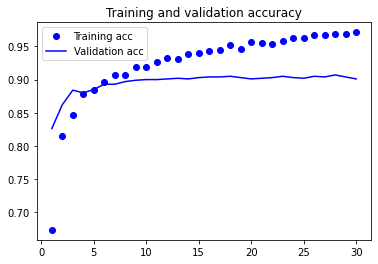

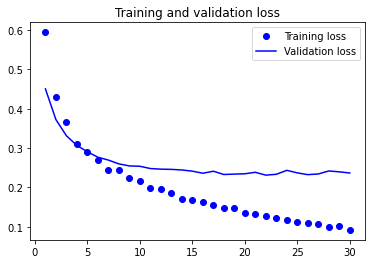

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()